# Topic Modeling with NMF and SVD

## The problem

Topic modeling is a fun way to start our study of NLP. We will use two popular **matrix decomposition techniques**. 

We start with a **term-document matrix**:

<img src="images/document_term.png" alt="term-document matrix" style="width: 80%"/>

source: [Introduction to Information Retrieval](http://player.slideplayer.com/15/4528582/#)

We can decompose this into one tall thin matrix times one wide short matrix (possibly with a diagonal matrix in between).

Notice that this representation does not take into account word order or sentence structure.  It's an example of a **bag of words** approach.

Latent Semantic Analysis (LSA) uses Singular Value Decomposition (SVD).

### Motivation

Consider the most extreme case - reconstructing the matrix using an outer product of two vectors. Clearly, in most cases we won't be able to reconstruct the matrix exactly. But if we had one vector with the relative frequency of each vocabulary word out of the total word count, and one with the average number of words per document, then that outer product would be as close as we can get.

Now consider increasing that matrices to two columns and two rows. The optimal decomposition would now be to cluster the documents into two groups, each of which has as different a distribution of words as possible to each other, but as similar as possible amongst the documents in the cluster. We will call those two groups "topics". And we would cluster the words into two groups, based on those which most frequently appear in each of the topics. 

## Getting started

We'll take a dataset of documents in several different categories, and find topics (consisting of groups of words) for them.  Knowing the actual categories helps us evaluate if the topics we find make sense.

We will try this with two different matrix factorizations: **Singular Value Decomposition (SVD)** and **Non-negative Matrix Factorization (NMF)**

In [138]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

In [139]:
%matplotlib inline
np.set_printoptions(suppress=True)

### Additional Resources

- [Data source](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html): Newsgroups are discussion groups on Usenet, which was popular in the 80s and 90s before the web really took off.  This dataset includes 18,000 newsgroups posts with 20 topics.
- [Chris Manning's book chapter](https://nlp.stanford.edu/IR-book/pdf/18lsi.pdf) on matrix factorization and LSI 
- Scikit learn [truncated SVD LSI details](http://scikit-learn.org/stable/modules/decomposition.html#lsa)

### Other Tutorials
- [Scikit-Learn: Out-of-core classification of text documents](http://scikit-learn.org/stable/auto_examples/applications/plot_out_of_core_classification.html): uses [Reuters-21578](https://archive.ics.uci.edu/ml/datasets/reuters-21578+text+categorization+collection) dataset (Reuters articles labeled with ~100 categories), HashingVectorizer
- [Text Analysis with Topic Models for the Humanities and Social Sciences](https://de.dariah.eu/tatom/index.html): uses [British and French Literature dataset](https://de.dariah.eu/tatom/datasets.html) of Jane Austen, Charlotte Bronte, Victor Hugo, and more

## Look at our data

Scikit Learn comes with a number of built-in datasets, as well as loading utilities to load several standard external datasets. This is a [great resource](http://scikit-learn.org/stable/datasets/), and the datasets include Boston housing prices, face images, patches of forest, diabetes, breast cancer, and more.  We will be using the newsgroups dataset.

Newsgroups are discussion groups on Usenet, which was popular in the 80s and 90s before the web really took off.  This dataset includes 18,000 newsgroups posts with 20 topics.  

In [140]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [141]:
newsgroups_train.filenames.shape, newsgroups_train.target.shape

((2034,), (2034,))

Let's look at some of the data.  Can you guess which category these messages are in?

In [26]:
print("\n".join(newsgroups_train.data[:3]))

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.c

hint: definition of *perijove* is the point in the orbit of a satellite of Jupiter nearest the planet's center 

In [27]:
np.array(newsgroups_train.target_names)[newsgroups_train.target[:3]]

array(['comp.graphics', 'talk.religion.misc', 'sci.space'], dtype='<U18')

The target attribute is the integer index of the category.

In [28]:
newsgroups_train.target[:10]

array([1, 3, 2, 0, 2, 0, 2, 1, 2, 1])

In [29]:
num_topics, num_top_words = 6, 8

## Stop words, stemming, lemmatization

### Stop words

From [Intro to Information Retrieval](https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html):

*Some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called stop words.*

*The general trend in IR systems over time has been from standard use of quite large stop lists (200-300 terms) to very small stop lists (7-12 terms) to no stop list whatsoever. Web search engines generally do not use stop lists.*

#### NLTK

In [2]:
from sklearn.feature_extraction import stop_words

sorted(list(stop_words.ENGLISH_STOP_WORDS))[:20]

['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amoungst']

There is no single universal list of stop words.

### Stemming and Lemmatization

from [Information Retrieval](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) textbook:

Are the below words the same?

*organize, organizes, and organizing*

*democracy, democratic, and democratization*

Stemming and Lemmatization both generate the root form of the words. 

Lemmatization uses the rules about a language.  The resulting tokens are all actual words

"Stemming is the poor-man’s lemmatization." (Noah Smith, 2011) Stemming is a crude heuristic that chops the ends off of words.  The resulting tokens may not be actual words. Stemming is faster.

In [142]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/racheltho/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [143]:
from nltk import stem

In [144]:
wnl = stem.WordNetLemmatizer()
porter = stem.porter.PorterStemmer()

In [145]:
word_list = ['feet', 'foot', 'foots', 'footing']

In [146]:
[wnl.lemmatize(word) for word in word_list]

['foot', 'foot', 'foot', 'footing']

In [147]:
[porter.stem(word) for word in word_list]

['feet', 'foot', 'foot', 'foot']

Your turn!  Now, try lemmatizing and stemming the following collections of words:

- fly, flies, flying
- organize, organizes, organizing
- universe, university

fastai/course-nlp

Stemming and lemmatization are language dependent.  Languages with more complex morphologies may show bigger benefits.  For example, Sanskrit has a very [large number of verb forms](https://en.wikipedia.org/wiki/Sanskrit_verbs). 

### Spacy

Stemming and lemmatization are implementation dependent.

Spacy is a very modern & fast nlp library. Spacy is opinionated, in that it typically offers one highly optimized way to do something (whereas nltk offers a huge variety of ways, although they are usually not as optimized).

You will need to install it.

if you use conda:
```
conda install -c conda-forge spacy
```
if you use pip:
```
pip install -U spacy
```

You will then need to download the English model:
```
spacy -m download en_core_web_sm
```

In [9]:
import spacy

In [80]:
from spacy.lemmatizer import Lemmatizer
lemmatizer = Lemmatizer()

In [81]:
[lemmatizer.lookup(word) for word in word_list]

['feet', 'foot', 'foots', 'footing']

Spacy doesn't offer a stemmer (since lemmatization is considered better-- this is an example of being opinionated!)

Stop words vary from library to library

In [12]:
nlp = spacy.load("en_core_web_sm")

In [13]:
sorted(list(nlp.Defaults.stop_words))[:20]

['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount']

#### Exercise: What stop words appear in spacy but not in sklearn?

In [27]:
#Exercise:


{'ca',
 'did',
 'does',
 'doing',
 'just',
 'make',
 'quite',
 'really',
 'regarding',
 'say',
 'unless',
 'used',
 'using',
 'various'}

#### Exercise: And what stop words are in sklearn but not spacy?

In [28]:
#Exercise:


frozenset({'amoungst',
           'bill',
           'cant',
           'co',
           'con',
           'couldnt',
           'cry',
           'de',
           'describe',
           'detail',
           'eg',
           'etc',
           'fill',
           'find',
           'fire',
           'found',
           'hasnt',
           'ie',
           'inc',
           'interest',
           'ltd',
           'mill',
           'sincere',
           'system',
           'thick',
           'thin',
           'un'})

### When to use these?

<img src="images/skomoroch.png" alt="" style="width: 65%"/>

These were long considered standard techniques, but they can often **hurt** your performance **if using deep learning**. Stemming, lemmatization, and removing stop words all involve throwing away information.

However, they can still be useful when working with simpler models.

### Another approach: sub-word units

[SentencePiece](https://github.com/google/sentencepiece) library from Google

## Data Processing

Next, scikit learn has a method that will extract all the word counts for us.  In the next lesson, we'll learn how to write our own version of CountVectorizer, to see what's happening underneath the hood.

In [148]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [149]:
import nltk
# nltk.download('punkt')

In [133]:
# from nltk import word_tokenize

# class LemmaTokenizer(object):
#     def __init__(self):
#         self.wnl = stem.WordNetLemmatizer()
#     def __call__(self, doc):
#         return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [150]:
vectorizer = CountVectorizer(stop_words='english') #, tokenizer=LemmaTokenizer())

In [151]:
vectors = vectorizer.fit_transform(newsgroups_train.data).todense() # (documents, vocab)
vectors.shape #, vectors.nnz / vectors.shape[0], row_means.shape

(2034, 26576)

In [108]:
print(len(newsgroups_train.data), vectors.shape)

2034 (2034, 26576)


In [109]:
vocab = np.array(vectorizer.get_feature_names())

In [110]:
vocab.shape

(26576,)

In [111]:
vocab[7000:7020]

array(['cosmonauts', 'cosmos', 'cosponsored', 'cost', 'costa', 'costar',
       'costing', 'costly', 'costruction', 'costs', 'cosy', 'cote',
       'couched', 'couldn', 'council', 'councils', 'counsel',
       'counselees', 'counselor', 'count'], dtype='<U80')

## Singular Value Decomposition (SVD)

"SVD is not nearly as famous as it should be." - Gilbert Strang

We would clearly expect that the words that appear most frequently in one topic would appear less frequently in the other - otherwise that word wouldn't make a good choice to separate out the two topics. Therefore, we expect the topics to be **orthogonal**.

The SVD algorithm factorizes a matrix into one matrix with **orthogonal columns** and one with **orthogonal rows** (along with a diagonal matrix, which contains the **relative importance** of each factor).

<img src="images/svd_fb.png" alt="" style="width: 80%"/>
(source: [Facebook Research: Fast Randomized SVD](https://research.fb.com/fast-randomized-svd/))

SVD is an **exact decomposition**, since the matrices it creates are big enough to fully cover the original matrix. SVD is extremely widely used in linear algebra, and specifically in data science, including:

- semantic analysis
- collaborative filtering/recommendations ([winning entry for Netflix Prize](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf))
- calculate Moore-Penrose pseudoinverse
- data compression
- principal component analysis

Latent Semantic Analysis (LSA) uses SVD.  You will sometimes hear topic modelling referred to as LSA.

In [152]:
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

CPU times: user 1min 19s, sys: 10 s, total: 1min 29s
Wall time: 3.63 s


In [153]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


Confirm this is a decomposition of the input.

In [157]:
s[:4]

array([433.92698542, 291.51012741, 240.71137677, 220.00048043])

In [158]:
np.diag(np.diag(s[:4]))

array([433.92698542, 291.51012741, 240.71137677, 220.00048043])

#### Answer

In [132]:
#Exercise: confrim that U, s, Vh is a decomposition of `vectors`


True

Confirm that U, V are orthonormal

#### Answer

In [39]:
#Exercise: Confirm that U, Vh are orthonormal


True

#### Topics

What can we say about the singular values s?

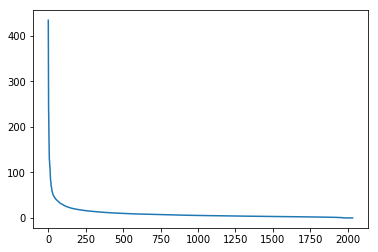

In [114]:
plt.plot(s);

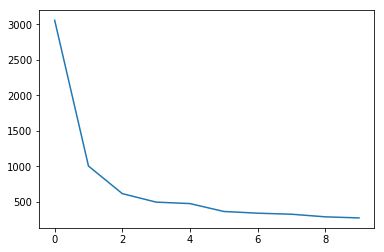

In [102]:
plt.plot(s[:10])

In [104]:
num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [115]:
show_topics(Vh[:10])

['critus ditto propagandist surname galacticentric kindergarten surreal imaginative',
 'jpeg gif file color quality image jfif format',
 'graphics edu pub mail 128 3d ray ftp',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display',
 'god atheists atheism religious believe religion argument true',
 'space nasa lunar mars probe moon missions probes',
 'image probe surface lunar mars probes moon orbit',
 'argument fallacy conclusion example true ad argumentum premises',
 'space larson image theory universe physical nasa material']

We get topics that match the kinds of clusters we would expect! This is despite the fact that this is an **unsupervised algorithm** - which is to say, we never actually told the algorithm how our documents are grouped.

We will return to SVD in **much more detail** later.  For now, the important takeaway is that we have a tool that allows us to exactly factor a matrix into orthogonal columns and orthogonal rows.

## Non-negative Matrix Factorization (NMF)

#### Motivation

<img src="images/face_pca.png" alt="PCA on faces" style="width: 80%"/>

(source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

A more interpretable approach:

<img src="images/face_outputs.png" alt="NMF on Faces" style="width: 80%"/>

(source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

#### Idea

Rather than constraining our factors to be *orthogonal*, another idea would to constrain them to be *non-negative*. NMF is a factorization of a non-negative data set $V$: $$ V = W H$$ into non-negative matrices $W,\; H$. Often positive factors will be **more easily interpretable** (and this is the reason behind NMF's popularity). 

<img src="images/face_nmf.png" alt="NMF on faces" style="width: 80%"/>

(source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

Nonnegative matrix factorization (NMF) is a non-exact factorization that factors into one skinny positive matrix and one short positive matrix.  NMF is NP-hard and non-unique.  There are a number of variations on it, created by adding different constraints. 

#### Applications of NMF

- [Face Decompositions](http://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html#sphx-glr-auto-examples-decomposition-plot-faces-decomposition-py)
- [Collaborative Filtering, eg movie recommendations](http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/)
- [Audio source separation](https://pdfs.semanticscholar.org/cc88/0b24791349df39c5d9b8c352911a0417df34.pdf)
- [Chemistry](http://ieeexplore.ieee.org/document/1532909/)
- [Bioinformatics](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-015-0485-4) and [Gene Expression](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2623306/)
- Topic Modeling (our problem!)

<img src="images/nmf_doc.png" alt="NMF on documents" style="width: 80%"/>

(source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

**More Reading**:

- [The Why and How of Nonnegative Matrix Factorization](https://arxiv.org/pdf/1401.5226.pdf)

### NMF from sklearn

We will use [scikit-learn's implementation of NMF](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html):

In [116]:
m,n=vectors.shape
d=5  # num topics

In [117]:
clf = decomposition.NMF(n_components=d, random_state=1)

W1 = clf.fit_transform(vectors)
H1 = clf.components_

In [118]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

### TF-IDF

[Topic Frequency-Inverse Document Frequency](http://www.tfidf.com/) (TF-IDF) is a way to normalize term counts by taking into account how often they appear in a document, how long the document is, and how commmon/rare the term is.

TF = (# occurrences of term t in document) / (# of words in documents)

IDF = log(# of documents / # documents with term t in it)

In [119]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data) # (documents, vocab)

In [160]:
newsgroups_train.data[10:20]

["a\n\nWhat about positional uncertainties in S-L 1993e?   I assume we know where\nand what Galileo is doing within a few meters.   But without the\nHGA,  don't we have to have some pretty good ideas, of where to look\nbefore imaging?  If the HGA was working,  they could slew around\nin near real time (Less speed of light delay).  But when they were\nimaging toutatis????  didn't someone have to get lucky on a guess to\nfind the first images?   \n\nAlso, I imagine S-L 1993e will be mostly a visual image.  so how will\nthat affect the other imaging missions.  with the LGA,  there is a real\ntight allocation of bandwidth.   It may be premature to hope for answers,\nbut I thought i'd throw it on the floor.",
 "I would like to program Tseng ET4000 to nonstandard 1024x768 mode by\nswitching to standard 1024x768 mode using BIOS and than changing some\ntiming details (0x3D4 registers 0x00-0x1F) but I don't know how to\nselect 36 MHz pixel clock I need. The BIOS function selects 40 MHz.\n\nIs t

In [120]:
W1 = clf.fit_transform(vectors_tfidf)
H1 = clf.components_

In [121]:
show_topics(H1)

['people don think just like objective say morality',
 'graphics thanks files image file program windows know',
 'space nasa launch shuttle orbit moon lunar earth',
 'ico bobbe tek beauchaine bronx manhattan sank queens',
 'god jesus bible believe christian atheism does belief']

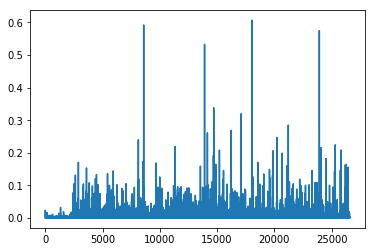

In [122]:
plt.plot(clf.components_[0])

In [99]:
clf.reconstruction_err_

43.71292605795277

### NMF in summary

Benefits: Fast and easy to use!

Downsides: took years of research and expertise to create

Notes:
- For NMF, matrix needs to be at least as tall as it is wide, or we get an error with fit_transform
- Can use df_min in CountVectorizer to only look at words that were in at least k of the split texts

## Truncated SVD

We saved a lot of time when we calculated NMF by only calculating the subset of columns we were interested in. Is there a way to get this benefit with SVD? Yes there is! It's called truncated SVD.  We are just interested in the vectors corresponding to the **largest** singular values.

<img src="images/svd_fb.png" alt="" style="width: 80%"/>

(source: [Facebook Research: Fast Randomized SVD](https://research.fb.com/fast-randomized-svd/))

#### Shortcomings of classical algorithms for decomposition:

- Matrices are "stupendously big"
- Data are often **missing or inaccurate**.  Why spend extra computational resources when imprecision of input limits precision of the output?
- **Data transfer** now plays a major role in time of algorithms.  Techniques the require fewer passes over the data may be substantially faster, even if they require more flops (flops = floating point operations).
- Important to take advantage of **GPUs**.

(source: [Halko](https://arxiv.org/abs/0909.4061))

#### Advantages of randomized algorithms:

- inherently stable
- performance guarantees do not depend on subtle spectral properties
- needed matrix-vector products can be done in parallel

(source: [Halko](https://arxiv.org/abs/0909.4061))

### Timing comparison

In [123]:
%time u, s, v = np.linalg.svd(vectors, full_matrices=False)

CPU times: user 1min 28s, sys: 9.3 s, total: 1min 37s
Wall time: 4.06 s


In [124]:
from sklearn import decomposition
import fbpca

In [125]:
%time u, s, v = decomposition.randomized_svd(vectors, 10)

CPU times: user 1min 18s, sys: 1.4 s, total: 1min 19s
Wall time: 3.03 s


Randomized SVD from Facebook's library fbpca:

In [126]:
%time u, s, v = fbpca.pca(vectors, 10)

CPU times: user 26 s, sys: 644 ms, total: 26.7 s
Wall time: 1.19 s


For more on randomized SVD, check out my [PyBay 2017 talk](https://www.youtube.com/watch?v=7i6kBz1kZ-A&list=PLtmWHNX-gukLQlMvtRJ19s7-8MrnRV6h6&index=7).

For significantly more on randomized SVD, check out the [Computational Linear Algebra course](https://github.com/fastai/numerical-linear-algebra).

## End